<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter08/focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

torch.manual_seed(42)
random.seed(0)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# load data
test_seq = [
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(10, shear=10)] + test_seq)
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=False, transform=test_transform),
    batch_size=1000, shuffle=True, **kwargs)

# create imbalanced data
torch.manual_seed(42)
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)

idx_to_del = [i for i, label in enumerate(train_loader.dataset.train_labels) 
              if random.random() > sample_probs[label]]
imbalanced_train_dataset = copy.deepcopy(train_dataset)
imbalanced_train_dataset.targets = np.delete(train_loader.dataset.targets, idx_to_del, axis=0)
imbalanced_train_dataset.data = np.delete(train_loader.dataset.data, idx_to_del, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


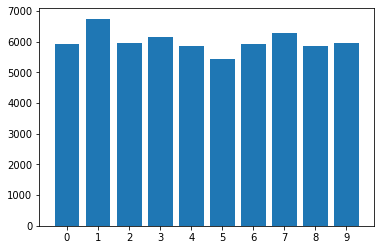

Sampling probability for each class:


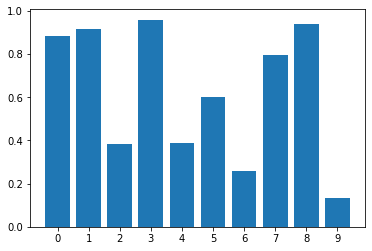

Imbalanced dataset: 37747 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


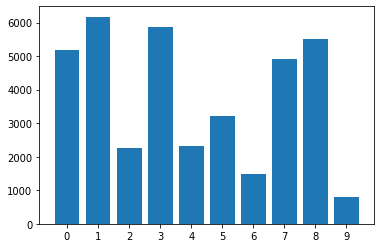

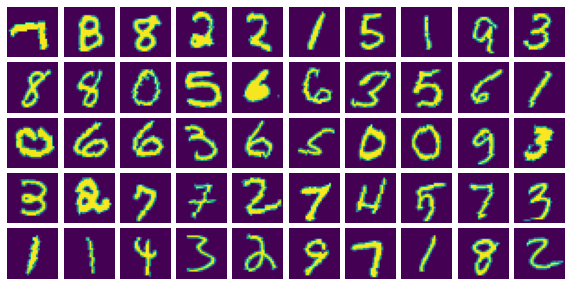

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns

def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
        
    
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
        
        
print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()
 
print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break
    

In [3]:
from torchvision.ops.focal_loss import sigmoid_focal_loss

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [4]:
def process(train_loader, test_loader, loss, epochs = 20, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = loss()

    def train(train_loader, loss):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    
    test_accs, confusion_mtxes = [], []
    for epoch in range(epochs):
        train(train_loader, loss)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs))
        
    vis(test_accs, confusion_mtxes, classe_labels)

Best test acc = 84.03%
Best test acc = 92.77%
Best test acc = 93.33%
Best test acc = 95.02%
Best test acc = 95.80%
Best test acc = 96.31%
Best test acc = 96.72%
Best test acc = 96.72%
Best test acc = 96.81%
Best test acc = 96.94%
Best test acc = 97.14%
Best test acc = 97.23%
Best test acc = 97.42%
Best test acc = 97.66%
Best test acc = 97.79%
Best test acc = 97.79%
Best test acc = 97.79%
Best test acc = 97.83%
Best test acc = 97.94%
Best test acc = 97.94%


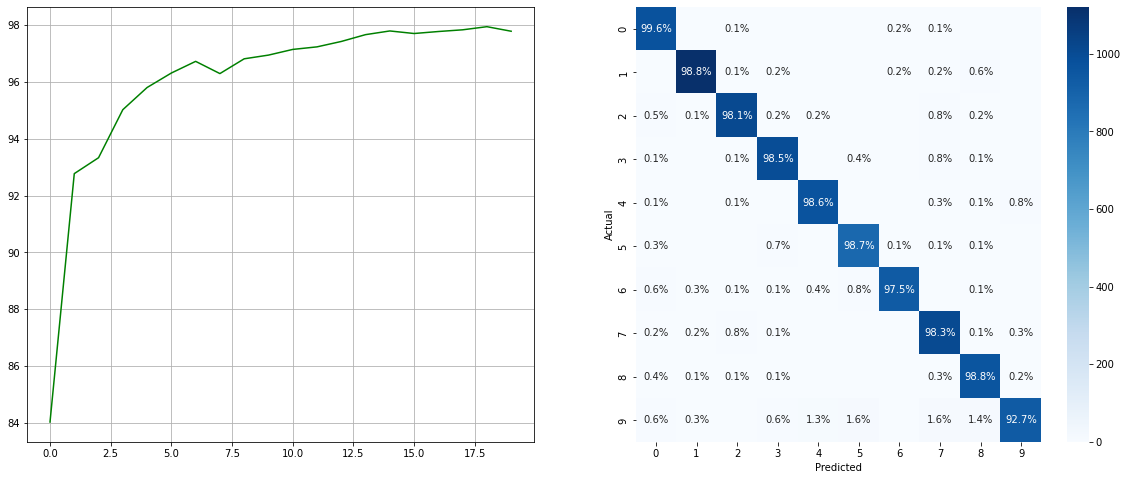

In [41]:
process(imbalanced_train_loader, test_loader, torch.nn.NLLLoss)

In [5]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    "Focal loss implemented using F.cross_entropy"
    def __init__(self, gamma: float = 2, alpha =.98) -> None:
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = "mean"

    def forward(self, inp: torch.Tensor, target: torch.Tensor):
        loss = torch.nn.NLLLoss()
        nll_loss = loss(inp, target) # nlloss = (label=1)*log_probability = log_probability
        p_t = torch.exp(-nll_loss) # take e ^ (log_probability) = probability
        loss = (1 - p_t)**self.gamma * self.alpha * nll_loss
        return loss.mean()

In [6]:
def process(train_loader, test_loader, loss, epochs = 20, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = loss()

    def train(train_loader, loss):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    
    test_accs, confusion_mtxes = [], []
    for epoch in range(epochs):
        train(train_loader, loss)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs))
        
    vis(test_accs, confusion_mtxes, classe_labels)

loss <class '__main__.FocalLoss'>
Best test acc = 83.26%
Best test acc = 89.20%
Best test acc = 90.89%
Best test acc = 92.35%
Best test acc = 92.89%
Best test acc = 93.61%
Best test acc = 94.75%
Best test acc = 94.75%
Best test acc = 94.75%
Best test acc = 94.92%
Best test acc = 95.44%
Best test acc = 95.53%
Best test acc = 95.67%
Best test acc = 95.67%
Best test acc = 95.67%
Best test acc = 95.74%
Best test acc = 95.91%
Best test acc = 95.91%
Best test acc = 96.06%
Best test acc = 96.06%
Best test acc = 96.08%
Best test acc = 96.14%
Best test acc = 96.21%
Best test acc = 96.51%
Best test acc = 96.51%
Best test acc = 96.52%
Best test acc = 96.59%
Best test acc = 96.59%
Best test acc = 96.65%
Best test acc = 96.88%
Best test acc = 96.88%
Best test acc = 96.88%
Best test acc = 96.93%
Best test acc = 97.09%
Best test acc = 97.09%
Best test acc = 97.09%
Best test acc = 97.09%
Best test acc = 97.09%
Best test acc = 97.09%
Best test acc = 97.15%
Best test acc = 97.31%
Best test acc = 97.31%


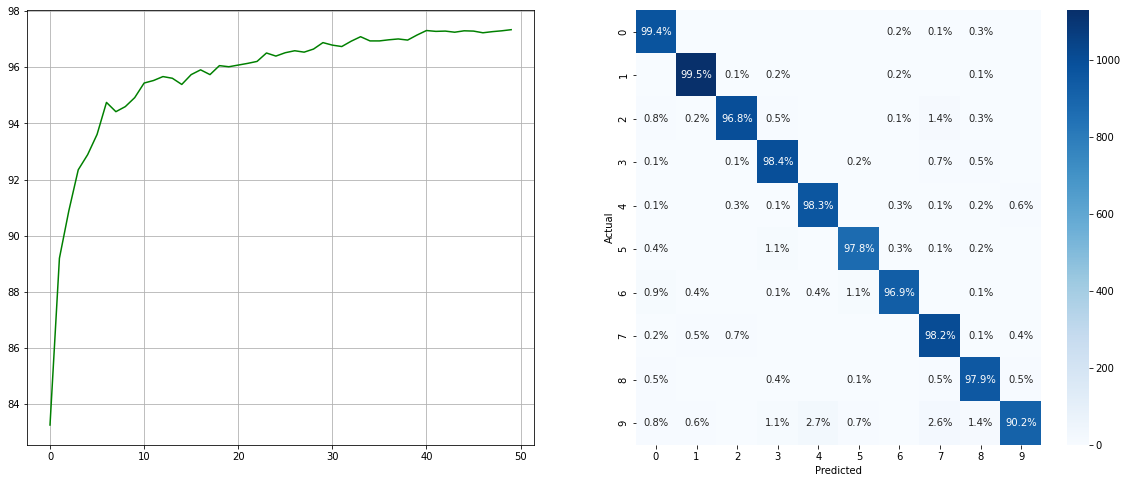

In [7]:
# using loss.mean()
process(imbalanced_train_loader, test_loader, FocalLoss, epochs=50)

# Using 'sigmoid_focal_loss' from 'torchvision.ops.focal_loss'

In [8]:
def process(train_loader, test_loader, loss, epochs = 20, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    def train(train_loader, loss):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
            loss = sigmoid_focal_loss(output, target_one_hot.float(), alpha=0.6, gamma=1.5, reduction="mean")
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    
    test_accs, confusion_mtxes = [], []
    for epoch in range(epochs):
        train(train_loader, loss)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs))
        
    vis(test_accs, confusion_mtxes, classe_labels)

loss <function sigmoid_focal_loss at 0x7fe8f083f280>
Best test acc = 42.60%
Best test acc = 46.59%
Best test acc = 53.30%
Best test acc = 63.66%
Best test acc = 71.47%
Best test acc = 75.84%
Best test acc = 78.16%
Best test acc = 79.31%
Best test acc = 80.95%
Best test acc = 82.50%
Best test acc = 83.61%
Best test acc = 84.64%
Best test acc = 84.64%
Best test acc = 85.13%
Best test acc = 85.80%
Best test acc = 86.41%
Best test acc = 86.45%
Best test acc = 87.40%
Best test acc = 87.40%
Best test acc = 88.40%
Best test acc = 88.40%
Best test acc = 88.52%
Best test acc = 89.44%
Best test acc = 89.50%
Best test acc = 89.53%
Best test acc = 90.16%
Best test acc = 90.16%
Best test acc = 90.35%
Best test acc = 90.88%
Best test acc = 91.31%
Best test acc = 91.31%
Best test acc = 91.76%
Best test acc = 91.76%
Best test acc = 91.76%
Best test acc = 91.76%
Best test acc = 91.76%
Best test acc = 92.13%
Best test acc = 92.61%
Best test acc = 92.61%
Best test acc = 92.61%
Best test acc = 92.98%
Best

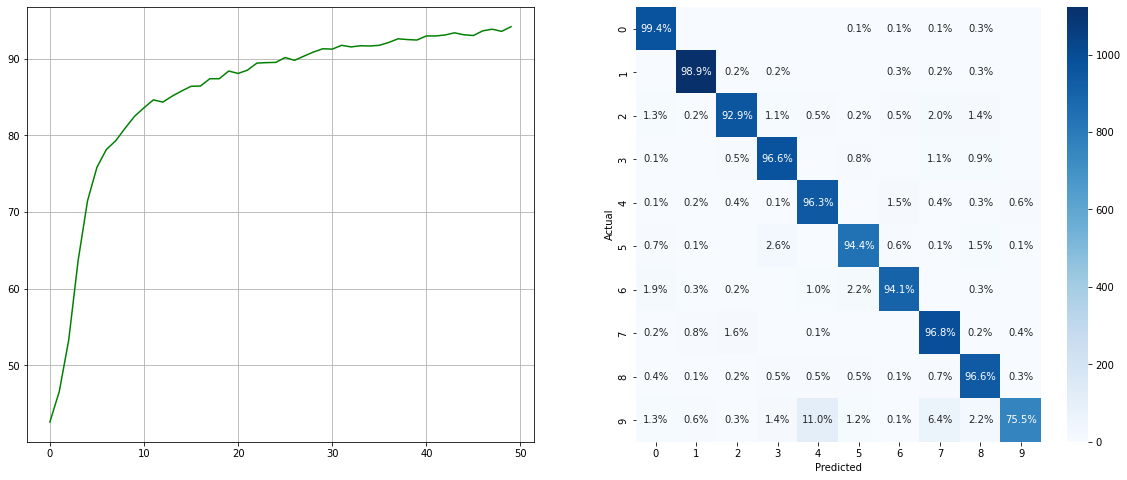

In [9]:
process(imbalanced_train_loader, test_loader, sigmoid_focal_loss, epochs=50)